In [1]:
import requests
import nltk
import matplotlib
import os
import glob
import nltk, re, pprint
import pandas as pd
from nltk import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim 
import numpy as np

## Data import and initial transformation

In [2]:
# enter list of authors of interest 
authors = ['Adriana+Herrera', 'Adrianne+Byrd', 'Alexa+Martin', 'Alexandria+House', 'Alexis+Daria', 'Alyssa+Cole', 
           'Beverly+Jenkins', 'Brenda+Jackson', 'Candace+Shaw', 'Charish+Reid', 'Cheris+Hodges', 'Christiana+Harrell', 
           'Christina+C+Jones', 'Delaney+Diamond', 'Denise+Williams', 'Elle+Wright', 'Farrah+Rochon', 'Jasmine+Guillory',
           'Kayla+Perrin', 'Keisha+Ervin', 'Kennedy+Ryan', 'Kianna+Alexander', 'Kiru+Taye', 'Kwana+Jackson', 'Latrivia+S+Nelson',
           'Lena+Hampton', 'Lena+Hart', 'Lindsay+Evans', 'Mia+Sosa', 'Mimi+Grace', 'Naima+Simone', 'Nana+Malone', 'Pepper+Pace',
           'Piper+Huguley', 'Rebekah+Weatherspoon', 'Reese+Ryan', 'Rilzy+Adams', 'Rochelle+Alers', 'Selena+Montgomery',
           'Sharon+C+Cooper', 'Sheryl+Lister', 'Stephanie+Nicole+Norris', 'Talia+Hibbert', 'Therese+Beharrie', 'Tiffany+Patterson',
           'Tina+Martin', 'Vanessa+Riley', 'Yahrah+St.+John']


# iterate through list of authors and make an api call for each author 
# add book title and description in dictionary 
book_dict = {}
author_dict = {}
for i in range(len(authors)):
    dynamic_request = "https://www.googleapis.com/books/v1/volumes?q=inauthor:" + str(authors[i])
    response_output = requests.get(dynamic_request).json()
    
    # now need to get every book within author profile from above
    for j in response_output['items']:
        # only get books with a description available, since we will use the description as basis of recommendations
        if 'description' in j['volumeInfo']: 
            book_description = j['volumeInfo']['description']
            book_title = j['volumeInfo']['title']
            book_author = j['volumeInfo']['authors'][0]

            # add the values to relevant dictionary
            book_dict[book_title] = book_description
            author_dict[book_title] = book_author


In [3]:
# convert the book titles into a list
book_titles = list(book_dict.keys())

# convert values into a list
book_text = list(book_dict.values())

# convert the book authors into a list
book_authors = list(author_dict.values())

# transform book titles into a book array to add as a column to a df later
book_array = np.asarray(book_titles)
author_array = np.asarray(book_authors)

## Text Analysis 

### Stopwords, stemming, and tokenizing
This section is focused on defining some functions to manipulate the book descriptions. First, I load NLTK's list of English stop words. Stop words are words like "a", "the", or "in" which don't convey significant meaning. 

In [4]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Define functions I will need before using the gensim model for recommendations.

In [5]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# import these modules 
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

In [6]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    # then stem 
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def tokenize_and_lemmatize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    # then lemmatize 
    lems = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lems

In [7]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if word.islower() and word.isalpha() and pos != 'NNP' and pos != 'NNPS']
    return non_propernouns


## Latent Diriechlet Allocation Models

I use Gensim's implementation in LDA. Need to preprocess the text using functions defined above.

In [8]:
from gensim import corpora, models, similarities 

# tokenize using relevant function 
%time tokenized_text = [tokenize_and_lemmatize(text) for text in book_text]

# remove stop words
%time preprocess = [[word for word in text if word not in stopwords] for text in tokenized_text]

# remove the POS
%time texts = [strip_proppers_POS(doc) for doc in preprocess]

CPU times: user 3.16 s, sys: 133 ms, total: 3.29 s
Wall time: 3.44 s
CPU times: user 159 ms, sys: 2.03 ms, total: 161 ms
Wall time: 163 ms
CPU times: user 3.35 s, sys: 78.2 ms, total: 3.43 s
Wall time: 3.5 s


In [9]:
# create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# remove extremes 
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [10]:
# run the LDA model 
%time lda = models.LdaModel(corpus, num_topics=20,id2word=dictionary, update_every=5, chunksize=1000, passes=100)

CPU times: user 42.9 s, sys: 565 ms, total: 43.5 s
Wall time: 49 s


In [11]:
# show topics 
lda.show_topics(20)

[(0,
  '0.013*"ha" + 0.011*"one" + 0.011*"family" + 0.009*"wa" + 0.009*"love" + 0.008*"life" + 0.005*"year" + 0.005*"man" + 0.005*"night" + 0.005*"romance"'),
 (1,
  '0.013*"ha" + 0.009*"want" + 0.008*"love" + 0.007*"know" + 0.006*"never" + 0.006*"chance" + 0.006*"help" + 0.005*"one" + 0.005*"need" + 0.004*"wa"'),
 (2,
  '0.009*"love" + 0.007*"life" + 0.006*"string" + 0.006*"ha" + 0.006*"issue" + 0.005*"family" + 0.005*"story" + 0.005*"justice" + 0.005*"wife" + 0.005*"novel"'),
 (3,
  '0.014*"ha" + 0.008*"never" + 0.007*"wa" + 0.006*"take" + 0.006*"love" + 0.006*"man" + 0.006*"life" + 0.005*"thing" + 0.005*"make" + 0.005*"come"'),
 (4,
  '0.009*"sexy" + 0.006*"thing" + 0.005*"life" + 0.005*"author" + 0.005*"one" + 0.005*"want" + 0.004*"woman" + 0.004*"real" + 0.004*"character" + 0.004*"build"'),
 (5,
  '0.013*"ha" + 0.011*"one" + 0.010*"life" + 0.007*"world" + 0.007*"wa" + 0.006*"even" + 0.006*"year" + 0.005*"find" + 0.005*"know" + 0.005*"day"'),
 (6,
  '0.016*"ha" + 0.012*"love" + 0.0

In [12]:
# convert top words into a matrix 
topics_matrix = lda.show_topics(formatted=False, num_words=100)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

["('love', 0.013458436)", "('one', 0.0101721715)", "('life', 0.0076697525)", "('man', 0.007663502)", "('book', 0.0075606606)", "('woman', 0.007269063)", "('new', 0.0067715268)", "('story', 0.0047707898)", "('city', 0.0045557804)", "('sex', 0.0044835727)", "('author', 0.0042455266)", "('need', 0.004008023)", "('end', 0.0040063853)", "('secret', 0.0039959317)", "('wa', 0.0039340877)", "('face', 0.003844528)", "('back', 0.0037635248)", "('family', 0.0037235722)", "('ha', 0.0036893836)", "('first', 0.003507069)", "('together', 0.0034392893)", "('want', 0.0034045763)", "('never', 0.0032706524)", "('character', 0.0032009387)", "('career', 0.0031481017)", "('come', 0.003069726)", "('friend', 0.0029109688)", "('may', 0.0028707874)", "('men', 0.0028707637)", "('worth', 0.0028402274)", "('well', 0.0028399597)", "('find', 0.0027485383)", "('someone', 0.0026705218)", "('bestselling', 0.0026653297)", "('part', 0.0026568028)", "('could', 0.002649129)", "('chemistry', 0.0026415475)", "('make', 0.0026

<ipython-input-12-15f4a6b71e5d>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  topics_matrix = np.array(topics_matrix)


In [13]:
# Compute Perplexity
print('Perplexity: ', lda.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda, texts=texts,
         dictionary=dictionary, coherence='c_uci')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -8.165608346669233
Coherence score:  -2.28666832230543


# Heatmap comparing book topics

In [14]:
topics = [lda[corpus[i]] for i in range(len(book_text))]

In [15]:
topics

[[(13, 0.9901024)],
 [(15, 0.98966986)],
 [(2, 0.15224983), (15, 0.40711492), (16, 0.4291437)],
 [(6, 0.99086326)],
 [(8, 0.9788866)],
 [(1, 0.9902041)],
 [(10, 0.98882127)],
 [(6, 0.6577933), (8, 0.32613185)],
 [(1, 0.5571402), (13, 0.42942333)],
 [(6, 0.20750439), (15, 0.7462718), (16, 0.03727254)],
 [(15, 0.9858158)],
 [(6, 0.93665826)],
 [(9, 0.9830326)],
 [(15, 0.625121), (19, 0.36035985)],
 [(17, 0.9784051)],
 [(6, 0.9208068)],
 [(13, 0.9844231)],
 [(6, 0.9788846)],
 [(6, 0.978882)],
 [(15, 0.9879701)],
 [(15, 0.98882073)],
 [(14, 0.16857277), (15, 0.8070951)],
 [(17, 0.97978336)],
 [(15, 0.99068224)],
 [(6, 0.98868823)],
 [(4, 0.9269111)],
 [(0, 0.9049844)],
 [(9, 0.9836186)],
 [(2, 0.96723723)],
 [(1, 0.27699566), (3, 0.2975484), (15, 0.34271613), (16, 0.072860256)],
 [(1, 0.022648744), (6, 0.96861136)],
 [(1, 0.15259731), (17, 0.84083176)],
 [(18, 0.99306434)],
 [(1, 0.9868042)],
 [(1, 0.99077487)],
 [(1, 0.96891373), (7, 0.017847324)],
 [(6, 0.9944434)],
 [(16, 0.033614237), 

In [16]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

# test function 
topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038537,NaN,NaN,NaN,NaN,NaN,0.091301,NaN,NaN,0.869287,NaN


In [17]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=20) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

document_topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.990102,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.989670,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.15225,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.407115,0.429144,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.990863,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.978887,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [18]:
document_topic.sort_values(14, ascending=False)[14].head(5)

362    0.992212
77     0.989443
119    0.988952
305    0.986984
46     0.985818
Name: 14, dtype: float64

<AxesSubplot:>

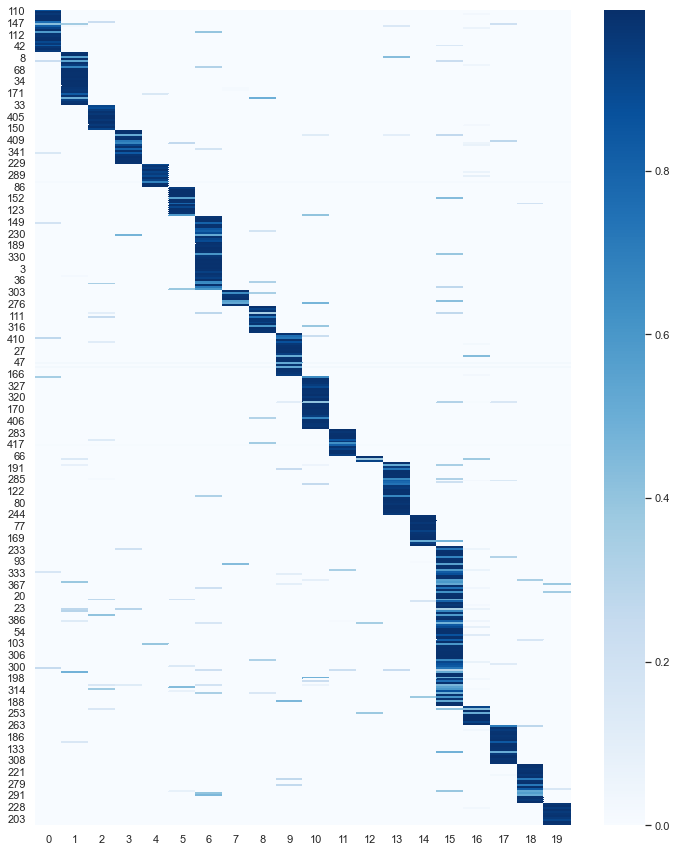

In [19]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(12,15)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index], cmap = 'Blues')

In [20]:
document_topic['book'] = book_array

document_topic['author'] = author_array

document_topic.tail()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,book,author
413,0.0,0.0,0.125172,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,Cappuccino Kisses,Yahrah St. John
414,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.969348,0.0,Red Carpet Redemption,Yahrah St. John
415,0.0,0.0,0.097923,0.0,0.0,0.0,0.278353,0.0,0.342671,0.0,...,0.0,0.0,0.0,0.266234,0.0,0.0,0.000000,0.0,Blind Date with the Spare Heir,Yahrah St. John
416,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.824067,0.0,0.0,0.162290,0.0,Can't Get Enough,Yahrah St. John
417,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.361225,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,Holiday Playbook,Yahrah St. John


In [21]:
bookData = document_topic.reset_index()
bookData

,index,0,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,book,author
0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.990102,0.0,0.000000,0.000000,0.0,0.000000,0.0,American Dreamer,Adriana Herrera
1,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.989670,0.000000,0.0,0.000000,0.0,American Love Story,Adriana Herrera
2,2,0.0,0.0,0.152250,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.407115,0.429144,0.0,0.000000,0.0,Here to Stay,Adriana Herrera
3,3,0.0,0.0,0.000000,0.0,0.0,0.0,0.990863,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,American Fairytale,Adriana Herrera
4,4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.978887,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,One Week to Claim It All,Adriana Herrera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,413,0.0,0.0,0.125172,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,Cappuccino Kisses,Yahrah St. John
414,414,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.969348,0.0,Red Carpet Redemption,Yahrah St. John
415,415,0.0,0.0,0.097923,0.0,0.0,0.0,0.278353,0.0,0.342671,...,0.0,0.000000,0.0,0.266234,0.000000,0.0,0.000000,0.0,Blind Date with the Spare Heir,Yahrah St. John
416,416,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.824067,0.000000,0.0,0.162290,0.0,Can't Get Enough,Yahrah St. John


# Recommendation System 

In [22]:
import itertools 

# define functions 
bookList = bookData['book']
bookIndex = bookData['index']
bookAuthor = bookData['author']
index2 = similarities.MatrixSimilarity(lda[corpus])


#userSelection = 6
userSelection = input("Hey, please enter the book you would like to find similar books for: ")

#listOfRelatedBooks = []
corpus_to_compare = []
names_of_related_books = []
identifiedTopic = 55

for book in range(len(bookList)-1):
    if userSelection == bookList[book]:
          corpusA = corpus[bookIndex[book]]
          vec_lda = lda[corpusA]
          corpus_to_compare.append(vec_lda)

sim = index2[vec_lda]
sims = sorted(enumerate(sim), key=lambda item: -item[1])
DoublelistOfRelatedBooks = [list(group) for val, group in itertools.groupby(sims, lambda x: x[1] >= .97) if val]
listOfRelatedBooks = DoublelistOfRelatedBooks[0]

# split tuples into two lists with book name and similarity score 
book_name, score = map(list, zip(*listOfRelatedBooks))

# iterate to get the name of the books and not the book index 
for book in book_name:
     if (bookIndex[book]== book_name).any():
        names_of_related_books.append(bookList[book])
        names_of_related_books.append(' by ' + str(bookAuthor[book]) + '\n')

print("Here's your list:" + '\n' + ''.join(names_of_related_books) + ' ')

print('Happy reading!')


Hey, please enter the book you would like to find similar books for: Get a Life, Chloe Brown
Here's your list:
A Princess in Theory by Alyssa Cole
Hearts on Hold by Charish Reid
Won't Go Home Without You by Cheris Hodges
Mixed Matters by Denise Williams
Island Fantasy by Kayla Perrin
Taste of Desire by Kayla Perrin
Love, Lies & Videotape by Kayla Perrin
Reel by Kennedy Ryan
Visualizing Blackness and the Creation of the African American Literary Tradition by Lena Hill
Something Borrowed by Lena Hart
Playing with Seduction by Reese Ryan
Never Tell by Selena Montgomery
Vengeful Intentions by Stephanie Nicole Norris
Get a Life, Chloe Brown by Talia Hibbert
Tales of a Mother Dreams of a Son by Tiffany Patterson
 
Happy reading!
